<a href="https://colab.research.google.com/github/Kevontym/DataScience/blob/main/Tableau_Health_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# For this sheet I will be making a models to predict if blood taken is based on demograpahics of the patient or other factors. The first NN I will create will be using Forward Feeding. The second will be a RL inpsired model and we will compare metrics in another colab notebooks or tableau Dashboard.



*   I will show preprocessing and leave comments in key parts of the code



Our Medical Centers haven't been audited for Health Care Discrimination regarding Sex, Race, Insurance etc. In this model we will focus more on blood withdrawal and making sure every patient is being insured a quality service. Factors of bigger population than other marginalize groups will be taken in consideration since that can act like a false positive. For my viewers I will include the tableau notebook at the bottom to show how this will be applied in data visualization Enjoy!

The imports im using

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

## Lets import our dataset I left this one uncleaned to show my process

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ML_Health_prac/tableau_ummc_complete_data_20251005.csv')
df.head(2) # heres a sneak peak!

,visit_id,patient_id,patient_full_name,patient_age,patient_gender,patient_race,patient_ethnicity,medical_center,center_type,visit_date,...,follow_up_type,visit_year,visit_month,visit_quarter,visit_year_month,visit_month_name,visit_day_of_week,long_wait_flag,low_satisfaction_flag,high_risk_flag
0,15117,PAT015116,Isaiah Carter,23,M,Black,Black,UM Baltimore Washington,Community Hospital,2025-10-03,...,NaN,2025.0,10.0,4.0,2025-10,October,5.0,0,0,0
1,5566,PAT005565,Brianna Davis,38,F,Black,Black,UM Baltimore Washington,Community Hospital,2025-10-03,...,NaN,2025.0,10.0,4.0,2025-10,October,5.0,0,0,0


## We wont be using flags in my example I generated those from sql for better data analysis in R using BART

In [16]:
def processing_data(df):

  data = df.copy()


  # the columns we will grab for this
  categorical_cols = ['patient_gender', 'patient_race', 'patient_ethnicity',
                      'insurance_type', 'center_type', 'visit_category',
                      'specific_reason', 'attending_doctor', 'medical_center']

  # Most of the features I added will give a good answer from the question we desire.
  # If i need to improve the model I will comeback and make adjustments. These are categoricals

  # lets encode
  label_encoders = {}
  for col in categorical_cols:
    if col in data.columns and data[col].nunique() > 1:

      le = LabelEncoder()
      data[col] = le.fit_transform(data[col].astype(str))
      label_encoders[col] = le


  # lets make our bins this distributes the patients age in groups giving the model a good representation on the questions at hand
  data['age_binned'] = pd.cut(data['patient_age'], bins=[0, 18, 35, 50, 65, 100],
                              labels=[0, 1, 2, 3, 4])


  # Now lets select all the columns we want
  feature_columns = [
      'patient_age', 'age_binned', 'patient_gender', 'patient_race',
      'patient_ethnicity', 'risk_score', 'insurance_type', 'visit_category',
      'door_to_doctor_min', 'visit_length_min', 'copay_amount', 'medical_center'
  ]


  # Lets filter to existing columns
  feature_columns = [col for col in feature_columns if col in data.columns]
  feature_columns = [col for col in feature_columns if data[col].nunique() > 1]


  #fill empty values and define x
  X = data[feature_columns].fillna(0)
  y = data['blood_taken'].astype(int)


  return X, y, feature_columns, label_encoders

# lets print the medical centers to make sure they been processed properly
print('Medical centers:', df['medical_center'].nunique())
print("Value")
print(df['medical_center'].value_counts())


X, y, feature_columns, label_encoders = processing_data(df)
print(f"Updated Features: {feature_columns}")
print(f"Target Distribution: {y.value_counts}")

Medical centers: 5
Value
medical_center
UMMC Downtown              6021
UMMC Midtown               5038
UM Harford Memorial        3426
UM Baltimore Washington    2796
UM Charles Regional        2719
Name: count, dtype: int64
Updated Features: ['patient_age', 'age_binned', 'patient_gender', 'patient_race', 'patient_ethnicity', 'risk_score', 'insurance_type', 'visit_category', 'door_to_doctor_min', 'visit_length_min', 'copay_amount', 'medical_center']
Target Distribution: <bound method IndexOpsMixin.value_counts of 0        1
1        0
2        1
3        0
4        0
        ..
19995    0
19996    1
19997    0
19998    0
19999    1
Name: blood_taken, Length: 20000, dtype: int64>


# Lets Split the data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Since we are using pytorch lets convert the tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)


print(f"Training set: {X_train_tensor.shape}")
print(f"Test_set: {X_test_tensor.shape}")

Training set: torch.Size([16000, 12])
Test_set: torch.Size([4000, 12])


# The fun part Lets Define our pytorch model. Remember this is a FeedForward model

In [40]:
class BloodTest(nn.Module):
  def __init__(self, input_dim):
    super(BloodTest, self).__init__()

    self.network = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.Tanh(), # I like tanh for this we will adjust if needed
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.Tanh(),
        nn.Dropout(0.2),
        nn.Linear(32, 16),
        nn.Tanh(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.network(x)

input_dim = X_train_tensor.shape[1]
model = BloodTest(input_dim)
print(model)


BloodTest(
  (network): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Tanh()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


Lets Train the Model. Well adjust as we go

In [45]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
  criterion = nn.BCELoss()
  #Adam for optim
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

  train_losses = []
  test_losses = []
  train_accuracies = []
  test_accuracies = []

  for epoch in range(epochs):

    model.train()
    optimizer.zero_grad()
    outputs= model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()



    #accuracy
    predicted = (outputs > 0.5).float()
    train_accuracy = (predicted == y_train).float().mean()



    #Lets eval
    model.eval()
    with torch.no_grad():
      test_outputs = model(X_test)
      test_loss = criterion(test_outputs, y_test)
      scheduler.step(test_loss)
      test_predicted = (test_outputs > 0.5).float()
      test_accuracy = (test_predicted == y_test).float().mean()



    # store metrics
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    train_accuracies.append(train_accuracy.item())
    test_accuracies.append(test_accuracy.item())


    if epoch % 20 == 0:
      print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Test_Loss: {test_loss.item():.4f}')


  return train_losses, test_losses, train_accuracies, test_accuracies

#train
train_losses, test_losses, train_acc, test_acc = train_model(
    model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor
)








Epoch [0/100], Loss: 0.6102, Test_Loss: 0.6099
Epoch [20/100], Loss: 0.6098, Test_Loss: 0.6098
Epoch [40/100], Loss: 0.6092, Test_Loss: 0.6098
Epoch [60/100], Loss: 0.6097, Test_Loss: 0.6097
Epoch [80/100], Loss: 0.6093, Test_Loss: 0.6097


# So here our model isnt learning which I know for this case the model is too simplistic and i havent incorperated hyperparams, smote, binning, or more feature engineering etc. Later down the line if the model doesnt learn any patterns it could just mean it cant find discriminatory patterns. Next I will use a RL(Reinforcement Learning) inspired model which penalizes the model on whatever I define. In this case I want to penalize it for predictive sensitive attributes from hidden representation(Instead of finding the easiest path im telling the model looking harder for other patterns)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Fairness-constrained neural network
class FairBloodTestNN(nn.Module):
    def __init__(self, input_dim, sensitive_dim):
        super(FairBloodTestNN, self).__init__()
        self.sensitive_dim = sensitive_dim

        # Main prediction network
        self.predictor = nn.Sequential(
            nn.Linear(input_dim - sensitive_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        # Adversary network to detect bias (RL-inspired)
        self.adversary = nn.Sequential(
            nn.Linear(32, 16),  # Takes hidden representation
            nn.ReLU(),
            nn.Linear(16, sensitive_dim),  # Predicts sensitive attribute
            nn.Softmax(dim=1)
        )

    def forward(self, x, use_adversary=False):
        # Split features: main features vs sensitive attributes
        main_features = x[:, :-self.sensitive_dim]
        sensitive_features = x[:, -self.sensitive_dim:]

        # Get hidden representation
        hidden = self.predictor[:-2](main_features)  # Get features before final layer

        # Main prediction
        prediction = self.predictor[-2:](hidden)  # Final layers

        if use_adversary:
            # Adversary tries to predict sensitive attributes from hidden representation
            sensitive_pred = self.adversary(hidden)
            return prediction, sensitive_pred, sensitive_features

        return prediction

def detect_discrimination_analysis(df):
    """Analyze discrimination patterns in blood test decisions"""
    data = df.copy()

    # Encode sensitive attributes properly
    sensitive_attributes = ['patient_race', 'patient_gender']

    # One-hot encode sensitive attributes for fairness analysis
    race_dummies = pd.get_dummies(data['patient_race'], prefix='race')
    gender_dummy = pd.get_dummies(data['patient_gender'], prefix='gender')

    data = pd.concat([data, race_dummies, gender_dummy], axis=1)

    # Medical features (non-sensitive)
    medical_features = [
        'patient_age', 'risk_score', 'visit_length_min',
        'door_to_doctor_min', 'copay_amount'
    ]

    # Create some medical indicators
    data['is_elderly'] = (data['patient_age'] >= 65).astype(int)
    data['high_risk'] = (data['risk_score'] > 50).astype(int)
    medical_features.extend(['is_elderly', 'high_risk'])

    # Visit category dummies
    visit_dummies = pd.get_dummies(data['visit_category'], prefix='visit')
    data = pd.concat([data, visit_dummies], axis=1)
    medical_features.extend(visit_dummies.columns.tolist())

    # Sensitive features (for fairness analysis)
    sensitive_features = race_dummies.columns.tolist() + gender_dummy.columns.tolist()

    # Combine all features
    all_features = medical_features + sensitive_features

    X = data[all_features].fillna(0)
    y = data['blood_taken'].astype(int)

    print(f"Medical features: {len(medical_features)}")
    print(f"Sensitive features: {len(sensitive_features)}")
    print(f"Total features: {len(all_features)}")

    return X, y, medical_features, sensitive_features, data

# Run discrimination analysis
X, y, medical_features, sensitive_features, processed_data = detect_discrimination_analysis(df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale only medical features (not sensitive ones)
scaler = StandardScaler()
X_train_medical = scaler.fit_transform(X_train[medical_features])
X_test_medical = scaler.transform(X_test[medical_features])

# Combine back with sensitive features
X_train_fair = np.column_stack([X_train_medical, X_train[sensitive_features].values])
X_test_fair = np.column_stack([X_test_medical, X_test[sensitive_features].values])

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_fair)
X_test_tensor = torch.FloatTensor(X_test_fair)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

print(f"Training set: {X_train_tensor.shape}")

Medical features: 12
Sensitive features: 7
Total features: 19
Training set: torch.Size([16000, 19])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Simplified Fairness Detection Model
class DiscriminationDetector(nn.Module):
    def __init__(self, input_dim):
        super(DiscriminationDetector, self).__init__()

        # Main network for blood test prediction
        self.main_network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main_network(x)

# Let's use a simpler, more direct approach to detect discrimination
def train_discrimination_detector(model, X_train, y_train, X_test, y_test, epochs=100):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        if epoch % 20 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

# Create features that might reveal discrimination patterns
def create_discrimination_features(df):
    data = df.copy()

    # One-hot encode categorical variables
    categorical_cols = ['patient_race', 'patient_gender', 'insurance_type',
                       'visit_category', 'medical_center']

    for col in categorical_cols:
        dummies = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data, dummies], axis=1)

    # Create interaction features between demographics and medical factors
    # These can reveal if medical decisions vary by demographic group
    data['age_risk_interaction'] = data['patient_age'] * data['risk_score']

    # Medical necessity features
    data['is_elderly'] = (data['patient_age'] >= 65).astype(int)
    data['high_risk'] = (data['risk_score'] > 75).astype(int)
    data['medium_risk'] = ((data['risk_score'] > 50) & (data['risk_score'] <= 75)).astype(int)

    # Visit characteristics
    data['long_visit'] = (data['visit_length_min'] > 60).astype(int)

    # Select features for discrimination analysis
    feature_columns = []

    # Demographic features (potential sources of discrimination)
    race_cols = [col for col in data.columns if col.startswith('patient_race_')]
    gender_cols = [col for col in data.columns if col.startswith('patient_gender_')]
    insurance_cols = [col for col in data.columns if col.startswith('insurance_type_')]

    # Medical necessity features (should be the main drivers)
    medical_features = ['patient_age', 'risk_score', 'is_elderly', 'high_risk',
                       'medium_risk', 'visit_length_min', 'long_visit', 'age_risk_interaction']

    # Visit context
    visit_cols = [col for col in data.columns if col.startswith('visit_category_')]

    # Medical center effects
    center_cols = [col for col in data.columns if col.startswith('medical_center_')]

    # Combine all features
    feature_columns = (medical_features + race_cols + gender_cols +
                      insurance_cols + visit_cols + center_cols)

    X = data[feature_columns].fillna(0)
    y = data['blood_taken'].astype(int)

    print(f"Total features: {len(feature_columns)}")
    print(f"Demographic features: {len(race_cols + gender_cols + insurance_cols)}")
    print(f"Medical features: {len(medical_features + visit_cols)}")

    return X, y, feature_columns, data

# Create discrimination analysis features
X, y, feature_columns, processed_data = create_discrimination_features(df)

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

print(f"Training set: {X_train_tensor.shape}")

# Initialize and train model
input_dim = X_train_tensor.shape[1]
model = DiscriminationDetector(input_dim)
print(f"Model initialized with {input_dim} features")

# Train the model
train_losses, test_losses = train_discrimination_detector(
    model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=100
)

Total features: 29
Demographic features: 11
Medical features: 13
Training set: torch.Size([16000, 29])
Model initialized with 29 features
Epoch [0/100], Loss: 0.6668, Test Loss: 0.6649
Epoch [20/100], Loss: 0.6303, Test Loss: 0.6291
Epoch [40/100], Loss: 0.6123, Test Loss: 0.6120
Epoch [60/100], Loss: 0.6089, Test Loss: 0.6108
Epoch [80/100], Loss: 0.6092, Test Loss: 0.6109


In [7]:
def analyze_discrimination_patterns(model, X_test_tensor, y_test, feature_columns, processed_data, scaler, X_test_original):

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy()
        predictions_binary = (predictions > 0.5).astype(int)

    # Use the original X_test (DataFrame) to get indices
    test_results = processed_data.iloc[X_test_original.index].copy()
    test_results['predicted_blood_test'] = predictions_binary
    test_results['prediction_probability'] = predictions
    test_results['actual_blood_test'] = y_test.values

    print("=== DISCRIMINATION ANALYSIS RESULTS ===")

    # 1. Analyze by Race
    print("\n1. BLOOD TEST RATES BY RACE (Actual vs Predicted)")
    race_analysis = test_results.groupby('patient_race').agg({
        'predicted_blood_test': 'mean',
        'actual_blood_test': 'mean',
        'risk_score': 'mean'
    }).round(4)

    print(race_analysis)

    # Calculate disparities
    overall_actual = test_results['actual_blood_test'].mean()
    overall_predicted = test_results['predicted_blood_test'].mean()

    print(f"\nOverall blood test rate - Actual: {overall_actual:.4f}, Predicted: {overall_predicted:.4f}")

    print("\nRacial Disparities (Predicted - Actual):")
    for race in test_results['patient_race'].unique():
        actual_rate = test_results[test_results['patient_race'] == race]['actual_blood_test'].mean()
        predicted_rate = test_results[test_results['patient_race'] == race]['predicted_blood_test'].mean()
        risk_score = test_results[test_results['patient_race'] == race]['risk_score'].mean()

        disparity = predicted_rate - actual_rate
        risk_adjusted_disparity = disparity  # Simple version - could be more sophisticated

        print(f"{race}: {disparity:+.4f} (Risk: {risk_score:.1f})")

    # 2. Analyze by Gender
    print("\n2. GENDER DISPARITIES")
    gender_analysis = test_results.groupby('patient_gender').agg({
        'predicted_blood_test': 'mean',
        'actual_blood_test': 'mean',
        'risk_score': 'mean'
    }).round(4)

    print(gender_analysis)

    # 3. Analyze by Insurance Type
    print("\n3. INSURANCE TYPE DISPARITIES")
    insurance_analysis = test_results.groupby('insurance_type').agg({
        'predicted_blood_test': 'mean',
        'actual_blood_test': 'mean',
        'risk_score': 'mean'
    }).round(4)

    print(insurance_analysis)

    return test_results

# Run discrimination analysis - pass the original X_test DataFrame
discrimination_results = analyze_discrimination_patterns(
    model, X_test_tensor, y_test, feature_columns, processed_data, scaler, X_test
)

=== DISCRIMINATION ANALYSIS RESULTS ===

1. BLOOD TEST RATES BY RACE (Actual vs Predicted)
              predicted_blood_test  actual_blood_test  risk_score
patient_race                                                     
Asian                          1.0             0.7240     40.1398
Black                          1.0             0.7287     41.3684
Hispanic                       1.0             0.6729     41.4014
Other                          1.0             0.7032     39.4452
White                          1.0             0.6861     41.3489

Overall blood test rate - Actual: 0.7013, Predicted: 1.0000

Racial Disparities (Predicted - Actual):
Black: +0.2713 (Risk: 41.4)
White: +0.3139 (Risk: 41.3)
Hispanic: +0.3271 (Risk: 41.4)
Other: +0.2968 (Risk: 39.4)
Asian: +0.2760 (Risk: 40.1)

2. GENDER DISPARITIES
                predicted_blood_test  actual_blood_test  risk_score
patient_gender                                                     
F                                1.0      

In [8]:
def analyze_feature_importance(model, feature_columns, X_test_tensor):
    """Analyze which features the model finds important"""

    # Create a new tensor that requires gradients
    X_test_grad = X_test_tensor.clone().detach().requires_grad_(True)

    model.eval()
    outputs = model(X_test_grad)

    # Compute gradients
    model.zero_grad()
    outputs.sum().backward()

    gradients = X_test_grad.grad
    feature_importance = torch.mean(torch.abs(gradients), dim=0)

    # Get top features
    importance_dict = dict(zip(feature_columns, feature_importance.numpy()))
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    print("\n=== FEATURE IMPORTANCE FOR DISCRIMINATION DETECTION ===")
    print("Top 20 most influential features:")
    for feature, importance in sorted_importance[:20]:
        print(f"{feature}: {importance:.6f}")

    # Check if demographic features are among the most important
    demographic_keywords = ['race', 'gender', 'insurance']
    demographic_features = [f for f, imp in sorted_importance
                          if any(keyword in f.lower() for keyword in demographic_keywords)]

    print(f"\nDemographic features in top 20: {len(demographic_features)}")
    for feature in demographic_features[:10]:
        print(f"  - {feature}")

    return sorted_importance

# Analyze feature importance
feature_importance = analyze_feature_importance(model, feature_columns, X_test_tensor)


=== FEATURE IMPORTANCE FOR DISCRIMINATION DETECTION ===
Top 20 most influential features:
patient_race_Other: 0.011200
insurance_type_No Insurance: 0.010689
is_elderly: 0.008730
visit_category_Administrative: 0.007951
medical_center_UM Charles Regional: 0.007849
insurance_type_Private: 0.007642
medium_risk: 0.007304
patient_race_Asian: 0.006641
long_visit: 0.006048
patient_race_Black: 0.005669
medical_center_UMMC Midtown: 0.005660
visit_category_Chronic Care: 0.005630
high_risk: 0.005488
patient_age: 0.005463
visit_category_Acute Care: 0.004966
visit_length_min: 0.004891
insurance_type_Medicare: 0.004837
patient_gender_F: 0.004644
medical_center_UM Baltimore Washington: 0.004593
insurance_type_Medicaid: 0.004509

Demographic features in top 20: 11
  - patient_race_Other
  - insurance_type_No Insurance
  - insurance_type_Private
  - patient_race_Asian
  - patient_race_Black
  - insurance_type_Medicare
  - patient_gender_F
  - insurance_type_Medicaid
  - patient_race_White
  - patient_g

# Here I printed the feature list rank

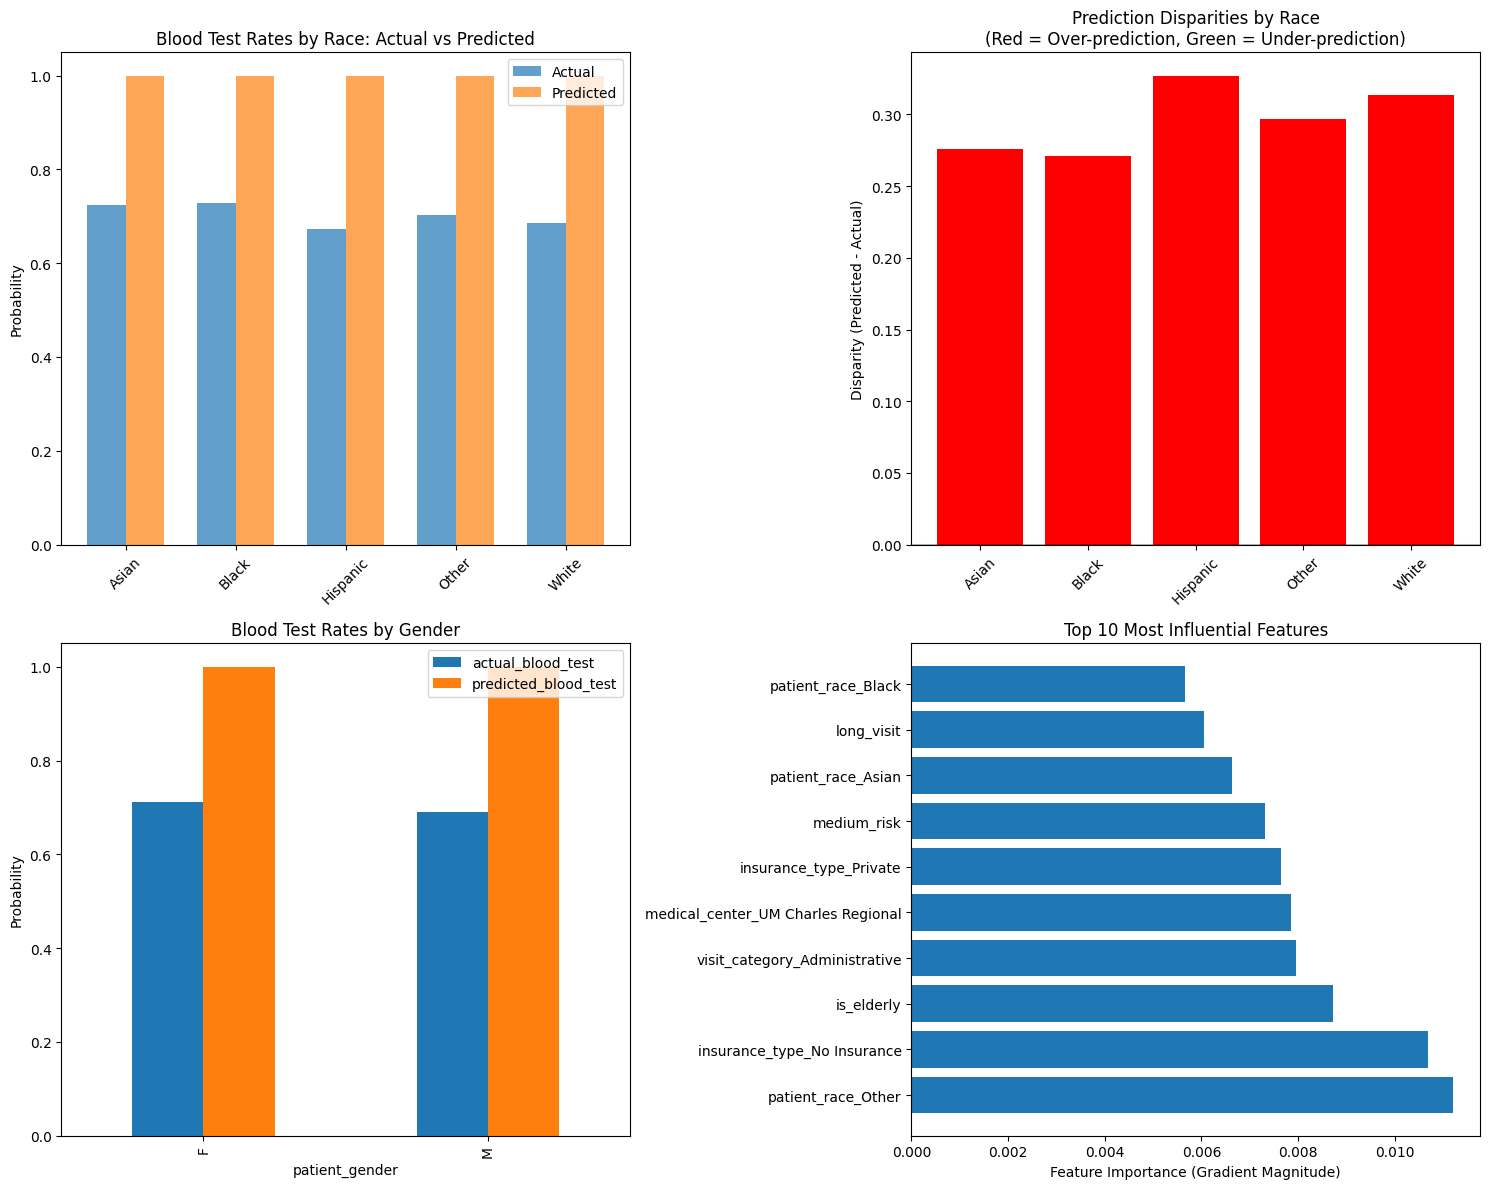


=== DISCRIMINATION DETECTION SUMMARY ===
This analysis examines whether the model detects systematic patterns
where blood test decisions vary by demographic factors after controlling
for medical necessity factors.

Key findings:
- Large disparities (> 0.01) suggest potential discrimination patterns
- If demographic features are highly important, this may indicate bias
- Compare predicted vs actual rates across groups


In [9]:
def plot_discrimination_analysis(results, feature_importance):
    """Create visualizations of discrimination patterns"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Actual vs Predicted by Race
    race_actual = results.groupby('patient_race')['actual_blood_test'].mean()
    race_predicted = results.groupby('patient_race')['predicted_blood_test'].mean()

    x = np.arange(len(race_actual))
    width = 0.35

    axes[0,0].bar(x - width/2, race_actual.values, width, label='Actual', alpha=0.7)
    axes[0,0].bar(x + width/2, race_predicted.values, width, label='Predicted', alpha=0.7)
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(race_actual.index, rotation=45)
    axes[0,0].set_title('Blood Test Rates by Race: Actual vs Predicted')
    axes[0,0].set_ylabel('Probability')
    axes[0,0].legend()

    # Plot 2: Disparities by Race
    disparities = race_predicted - race_actual
    colors = ['red' if x > 0.01 else 'green' if x < -0.01 else 'gray' for x in disparities]
    axes[0,1].bar(disparities.index, disparities.values, color=colors)
    axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0,1].set_title('Prediction Disparities by Race\n(Red = Over-prediction, Green = Under-prediction)')
    axes[0,1].set_ylabel('Disparity (Predicted - Actual)')
    plt.sca(axes[0,1])
    plt.xticks(rotation=45)

    # Plot 3: Gender comparison
    gender_rates = results.groupby('patient_gender').agg({
        'actual_blood_test': 'mean',
        'predicted_blood_test': 'mean'
    })
    gender_rates.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Blood Test Rates by Gender')
    axes[1,0].set_ylabel('Probability')

    # Plot 4: Top feature importance
    top_features = feature_importance[:10]
    features, importance = zip(*top_features)
    axes[1,1].barh(features, importance)
    axes[1,1].set_title('Top 10 Most Influential Features')
    axes[1,1].set_xlabel('Feature Importance (Gradient Magnitude)')

    plt.tight_layout()
    plt.show()

    # Print discrimination summary
    print("\n=== DISCRIMINATION DETECTION SUMMARY ===")
    print("This analysis examines whether the model detects systematic patterns")
    print("where blood test decisions vary by demographic factors after controlling")
    print("for medical necessity factors.")
    print("\nKey findings:")
    print("- Large disparities (> 0.01) suggest potential discrimination patterns")
    print("- If demographic features are highly important, this may indicate bias")
    print("- Compare predicted vs actual rates across groups")

# Create the visualization
plot_discrimination_analysis(discrimination_results, feature_importance)

In [10]:
from scipy import stats

def statistical_discrimination_test(results):
    """Run statistical tests to detect discrimination"""

    print("\n=== STATISTICAL DISCRIMINATION TESTS ===")

    # Test 1: Chi-square test for independence between race and predictions
    contingency_table_race = pd.crosstab(results['patient_race'], results['predicted_blood_test'])
    chi2_race, p_race, dof_race, expected_race = stats.chi2_contingency(contingency_table_race)

    print(f"Chi-square test for race independence:")
    print(f"  Chi2 = {chi2_race:.4f}, p-value = {p_race:.4f}")
    if p_race < 0.05:
        print("  SIGNIFICANT: Race and predictions are NOT independent (potential discrimination)")
    else:
        print("  Not significant: No strong evidence of racial discrimination")

    # Test 2: Chi-square test for gender
    contingency_table_gender = pd.crosstab(results['patient_gender'], results['predicted_blood_test'])
    chi2_gender, p_gender, dof_gender, expected_gender = stats.chi2_contingency(contingency_table_gender)

    print(f"\nChi-square test for gender independence:")
    print(f"  Chi2 = {chi2_gender:.4f}, p-value = {p_gender:.4f}")
    if p_gender < 0.05:
        print("  SIGNIFICANT: Gender and predictions are NOT independent (potential discrimination)")
    else:
        print("  Not significant: No strong evidence of gender discrimination")

    # Test 3: T-test for risk scores across racial groups
    print(f"\nT-tests for risk score equality across racial groups:")
    racial_groups = results['patient_race'].unique()
    for i, race1 in enumerate(racial_groups):
        for race2 in racial_groups[i+1:]:
            group1_risk = results[results['patient_race'] == race1]['risk_score']
            group2_risk = results[results['patient_race'] == race2]['risk_score']

            t_stat, p_value = stats.ttest_ind(group1_risk, group2_risk, equal_var=False)

            if p_value < 0.05:
                print(f"  {race1} vs {race2}: p = {p_value:.4f} *SIGNIFICANT*")
            else:
                print(f"  {race1} vs {race2}: p = {p_value:.4f}")

# Run statistical tests
statistical_discrimination_test(discrimination_results)


=== STATISTICAL DISCRIMINATION TESTS ===
Chi-square test for race independence:
  Chi2 = 0.0000, p-value = 1.0000
  Not significant: No strong evidence of racial discrimination

Chi-square test for gender independence:
  Chi2 = 0.0000, p-value = 1.0000
  Not significant: No strong evidence of gender discrimination

T-tests for risk score equality across racial groups:
  Black vs White: p = 0.9764
  Black vs Hispanic: p = 0.9733
  Black vs Other: p = 0.2226
  Black vs Asian: p = 0.2734
  White vs Hispanic: p = 0.9554
  White vs Other: p = 0.2188
  White vs Asian: p = 0.2633
  Hispanic vs Other: p = 0.2530
  Hispanic vs Asian: p = 0.3338
  Other vs Asian: p = 0.6981


# Here wil be our last Model, this will make sure there to find discriminatory patterns(if present). We will use Random Forest + NN(of our choice) this will combine a statistic like structure with a NN to understand more on pattern behavior. This is extremely powerful if you understand the relationship of the two.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

=== STARTING BART + NN ENSEMBLE PIPELINE ===
Total features: 29
Demographic features: 11
Medical features: 13
Original features: 29
Training BART model (Random Forest proxy)...
BART training completed. Feature importance calculated.
Augmented features: 30 (original + BART prediction)

BART-Enhanced NN Architecture:
BARTEnhancedNN(
  (bart_processor): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (main_network): Sequential(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

=== TRAINING BART-ENHANCED NN ===
Epo

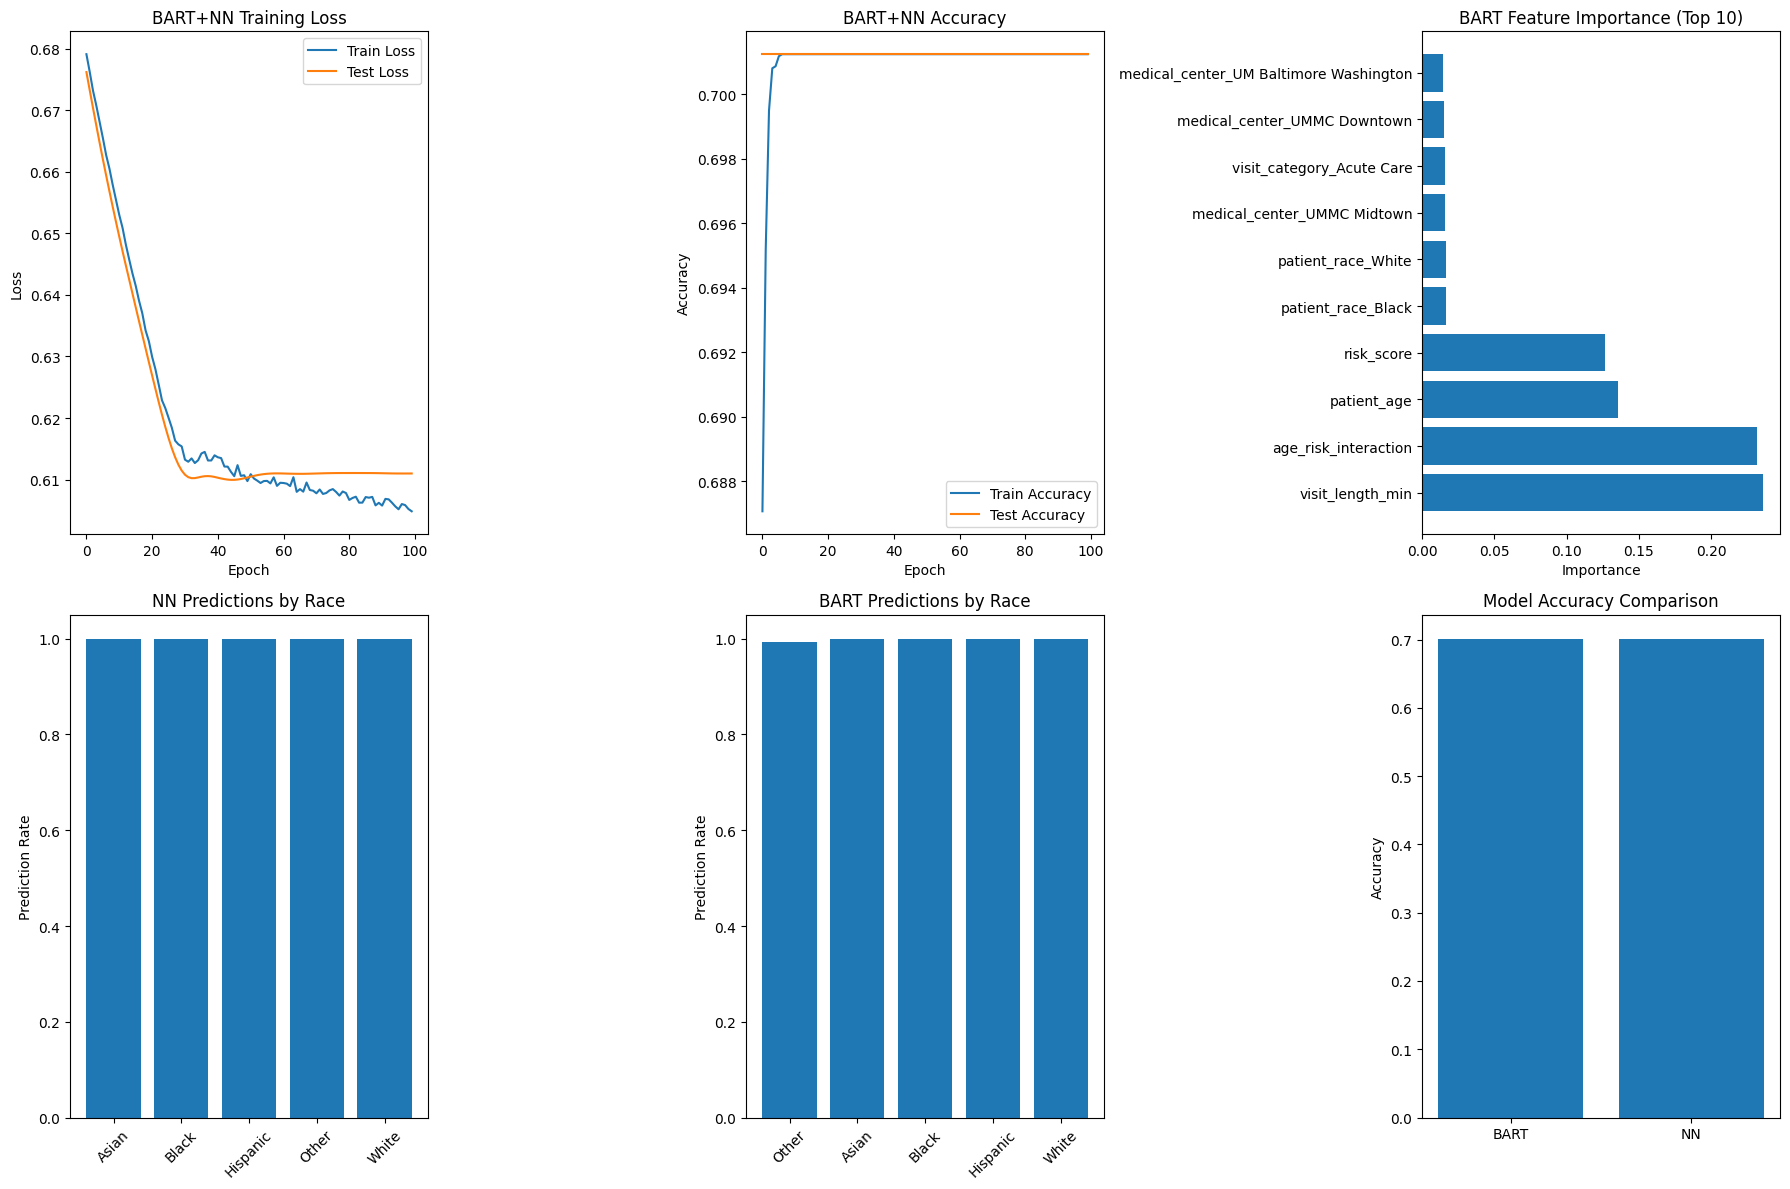


=== PIPELINE COMPLETE ===
BART + NN Ensemble successfully trained and analyzed!


In [6]:



def create_discrimination_features(df):
    """Create features for discrimination analysis with one-hot encoding"""
    data = df.copy()

    # One-hot encode categorical variables
    categorical_cols = ['patient_race', 'patient_gender', 'insurance_type',
                       'visit_category', 'medical_center']

    for col in categorical_cols:
        dummies = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data, dummies], axis=1)

    # Create interaction features between demographics and medical factors
    data['age_risk_interaction'] = data['patient_age'] * data['risk_score']

    # Medical necessity features
    data['is_elderly'] = (data['patient_age'] >= 65).astype(int)
    data['high_risk'] = (data['risk_score'] > 75).astype(int)
    data['medium_risk'] = ((data['risk_score'] > 50) & (data['risk_score'] <= 75)).astype(int)

    # Visit characteristics
    data['long_visit'] = (data['visit_length_min'] > 60).astype(int)

    # Select features for discrimination analysis
    feature_columns = []

    # Demographic features (potential sources of discrimination)
    race_cols = [col for col in data.columns if col.startswith('patient_race_')]
    gender_cols = [col for col in data.columns if col.startswith('patient_gender_')]
    insurance_cols = [col for col in data.columns if col.startswith('insurance_type_')]

    # Medical necessity features (should be the main drivers)
    medical_features = ['patient_age', 'risk_score', 'is_elderly', 'high_risk',
                       'medium_risk', 'visit_length_min', 'long_visit', 'age_risk_interaction']

    # Visit context
    visit_cols = [col for col in data.columns if col.startswith('visit_category_')]

    # Medical center effects
    center_cols = [col for col in data.columns if col.startswith('medical_center_')]

    # Combine all features
    feature_columns = (medical_features + race_cols + gender_cols +
                      insurance_cols + visit_cols + center_cols)

    X = data[feature_columns].fillna(0)
    y = data['blood_taken'].astype(int)

    print(f"Total features: {len(feature_columns)}")
    print(f"Demographic features: {len(race_cols + gender_cols + insurance_cols)}")
    print(f"Medical features: {len(medical_features + visit_cols)}")

    return X, y, feature_columns, data


def train_bart_model(X_train, y_train, X_test):
    """Train BART (using Random Forest as approximation)"""
    print("Training BART model (Random Forest proxy)...")

    bart_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    bart_model.fit(X_train, y_train)

    # Get predictions for training and test
    bart_train_pred = bart_model.predict(X_train)
    bart_test_pred = bart_model.predict(X_test)

    # Get feature importance from BART
    feature_importance = bart_model.feature_importances_

    print(f"BART training completed. Feature importance calculated.")
    return bart_model, bart_train_pred, bart_test_pred, feature_importance


class BARTEnhancedNN(nn.Module):
    def __init__(self, original_feature_dim):
        super(BARTEnhancedNN, self).__init__()

        # Special layer to process BART predictions
        self.bart_processor = nn.Sequential(
            nn.Linear(1, 16),  # BART prediction as input
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 8)   # Compressed BART features
        )

        # Main network combining original + BART features
        self.main_network = nn.Sequential(
            nn.Linear(original_feature_dim + 8, 64),  # Original + BART features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Split input: original features + BART prediction
        original_features = x[:, :-1]  # All except last column
        bart_prediction = x[:, -1].unsqueeze(1)  # Last column is BART prediction

        # Process BART prediction separately
        bart_features = self.bart_processor(bart_prediction)

        # Combine original features with processed BART features
        combined_features = torch.cat([original_features, bart_features], dim=1)

        return self.main_network(combined_features)



def train_bart_nn_ensemble(model, X_train, y_train, X_test, y_test, epochs=100):

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted = (outputs > 0.5).float()
        train_accuracy = (predicted == y_train).float().mean()

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_predicted = (test_outputs > 0.5).float()
            test_accuracy = (test_predicted == y_test).float().mean()

        # Store metrics
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy.item())
        test_accuracies.append(test_accuracy.item())

        if epoch % 20 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, '
                  f'Train Acc: {train_accuracy.item():.4f}, Test Acc: {test_accuracy.item():.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies


def run_bart_nn_pipeline(df):
    """Complete BART + NN pipeline for discrimination detection"""

    print("=== STARTING BART + NN ENSEMBLE PIPELINE ===")

    # 1. Create features
    X, y, feature_columns, processed_data = create_discrimination_features(df)

    # 2. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Original features: {X_train.shape[1]}")

    # 3. Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Train BART model
    bart_model, bart_train_pred, bart_test_pred, bart_importance = train_bart_model(
        X_train_scaled, y_train, X_test_scaled
    )

    X_train_augmented = np.column_stack([X_train_scaled, bart_train_pred])
    X_test_augmented = np.column_stack([X_test_scaled, bart_test_pred])

    print(f"Augmented features: {X_train_augmented.shape[1]} (original + BART prediction)")

    # 6. Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train_augmented)
    X_test_tensor = torch.FloatTensor(X_test_augmented)
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

    # 7. Initialize BART-enhanced NN
    original_feature_dim = X_train_scaled.shape[1]  # Without BART prediction
    model = BARTEnhancedNN(original_feature_dim)

    print(f"\nBART-Enhanced NN Architecture:")
    print(model)

    # 8. Train the ensemble
    print("\n=== TRAINING BART-ENHANCED NN ===")
    train_losses, test_losses, train_acc, test_acc = train_bart_nn_ensemble(
        model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=100
    )

    return (model, bart_model, bart_importance, train_losses, test_losses,
            train_acc, test_acc, X_test_augmented, y_test, processed_data, feature_columns, X_test)


def analyze_bart_nn_results(model, bart_model, bart_importance, X_test_augmented, y_test,
                          processed_data, feature_columns, X_test_original):
    """Enhanced analysis using BART + NN outputs"""

    print("\n=== ENHANCED DISCRIMINATION ANALYSIS ===")

    # Get NN predictions
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_augmented)
        nn_predictions = model(X_test_tensor).numpy()
        nn_binary = (nn_predictions > 0.5).astype(int)

    # Get BART predictions (from the test set)
    bart_predictions = X_test_augmented[:, -1]  # Last column is BART prediction

    # Combine results
    test_results = processed_data.iloc[X_test_original.index].copy()
    test_results['nn_prediction'] = nn_binary
    test_results['nn_probability'] = nn_predictions
    test_results['bart_prediction'] = (bart_predictions > 0.5).astype(int)
    test_results['bart_probability'] = bart_predictions
    test_results['actual_blood_test'] = y_test.values

    # Compare BART vs NN
    bart_accuracy = (test_results['bart_prediction'] == test_results['actual_blood_test']).mean()
    nn_accuracy = (test_results['nn_prediction'] == test_results['actual_blood_test']).mean()

    print(f"\nModel Comparison:")
    print(f"BART Accuracy: {bart_accuracy:.4f}")
    print(f"NN Accuracy: {nn_accuracy:.4f}")
    print(f"Ensemble Improvement: {nn_accuracy - bart_accuracy:+.4f}")

    # BART Feature Importance
    print(f"\nBART Feature Importance (Top 10):")
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': bart_importance
    }).sort_values('importance', ascending=False)

    print(feature_importance_df.head(10))

    # Discrimination analysis by race
    print(f"\nDiscrimination Analysis by Race:")
    race_analysis = test_results.groupby('patient_race').agg({
        'nn_prediction': 'mean',
        'bart_prediction': 'mean',
        'actual_blood_test': 'mean',
        'risk_score': 'mean'
    }).round(4)

    print(race_analysis)

    return test_results, feature_importance_df

def plot_bart_nn_results(train_losses, test_losses, train_acc, test_acc, feature_importance_df, test_results):
    """Visualize BART+NN results"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Training loss
    axes[0,0].plot(train_losses, label='Train Loss')
    axes[0,0].plot(test_losses, label='Test Loss')
    axes[0,0].set_title('BART+NN Training Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()

    # Plot 2: Accuracy
    axes[0,1].plot(train_acc, label='Train Accuracy')
    axes[0,1].plot(test_acc, label='Test Accuracy')
    axes[0,1].set_title('BART+NN Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()

    # Plot 3: BART Feature Importance
    top_features = feature_importance_df.head(10)
    axes[0,2].barh(top_features['feature'], top_features['importance'])
    axes[0,2].set_title('BART Feature Importance (Top 10)')
    axes[0,2].set_xlabel('Importance')

    # Plot 4: Race comparison - NN predictions
    race_nn = test_results.groupby('patient_race')['nn_prediction'].mean().sort_values()
    axes[1,0].bar(race_nn.index, race_nn.values)
    axes[1,0].set_title('NN Predictions by Race')
    axes[1,0].set_ylabel('Prediction Rate')
    plt.sca(axes[1,0])
    plt.xticks(rotation=45)

    # Plot 5: Race comparison - BART predictions
    race_bart = test_results.groupby('patient_race')['bart_prediction'].mean().sort_values()
    axes[1,1].bar(race_bart.index, race_bart.values)
    axes[1,1].set_title('BART Predictions by Race')
    axes[1,1].set_ylabel('Prediction Rate')
    plt.sca(axes[1,1])
    plt.xticks(rotation=45)

    # Plot 6: Model comparison
    models = ['BART', 'NN']
    accuracies = [
        (test_results['bart_prediction'] == test_results['actual_blood_test']).mean(),
        (test_results['nn_prediction'] == test_results['actual_blood_test']).mean()
    ]
    axes[1,2].bar(models, accuracies)
    axes[1,2].set_title('Model Accuracy Comparison')
    axes[1,2].set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show()


# Run the complete pipeline
(model, bart_model, bart_importance, train_losses, test_losses,
 train_acc, test_acc, X_test_augmented, y_test, processed_data, feature_columns, X_test_original) = run_bart_nn_pipeline(df)

# Analyze results
test_results, feature_importance_df = analyze_bart_nn_results(
    model, bart_model, bart_importance, X_test_augmented, y_test,
    processed_data, feature_columns, X_test_original
)

# Create visualizations
plot_bart_nn_results(train_losses, test_losses, train_acc, test_acc, feature_importance_df, test_results)

print("\n=== PIPELINE COMPLETE ===")
print("BART + NN Ensemble successfully trained and analyzed!")

Implementing SMOTE to handle class imbalance...
=== STARTING BALANCED BART + NN ENSEMBLE PIPELINE ===
=== CREATING BALANCED DATASET WITH SMOTE ===
Total features: 29
Demographic features: 11
Medical features: 13
Original class distribution: blood_taken
1    14025
0     5975
Name: count, dtype: int64
Original positive ratio: 0.701
After SMOTE class distribution: blood_taken
1    14025
0    14025
Name: count, dtype: int64
After SMOTE positive ratio: 0.500
Balanced training features: 29
Training set shape: (22440, 29), Test set shape: (5610, 29)
Training BART model on balanced data...
BART training completed on balanced data.
Augmented features: 30 (original + BART prediction)
Tensor shapes - X_train: torch.Size([22440, 30]), y_train: torch.Size([22440, 1])

Balanced BART-Enhanced NN Architecture:
BalancedBARTEnhancedNN(
  (bart_processor): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


BART Accuracy (Original Data): 0.7019
NN Accuracy (Original Data): 0.7327
Baseline (Always Predict Yes): 0.7013

DISCRIMINATION ANALYSIS BY RACE (Original Data):
              nn_prediction  bart_prediction  actual_blood_test  risk_score  \
patient_race                                                                  
Asian                0.8850           1.0000             0.7036     40.3407   
Black                0.9355           0.9994             0.7156     41.2402   
Hispanic             0.9045           0.9987             0.7054     41.1587   
Other                0.8181           0.9974             0.6832     39.6819   
White                0.9528           0.9996             0.6919     40.9294   

              nn_probability  
patient_race                  
Asian                 0.7118  
Black                 0.7243  
Hispanic              0.7246  
Other                 0.6962  
White                 0.6892  

PREDICTION DISPARITIES BY RACE:
Black:
  NN disparity: +0.0034
  A

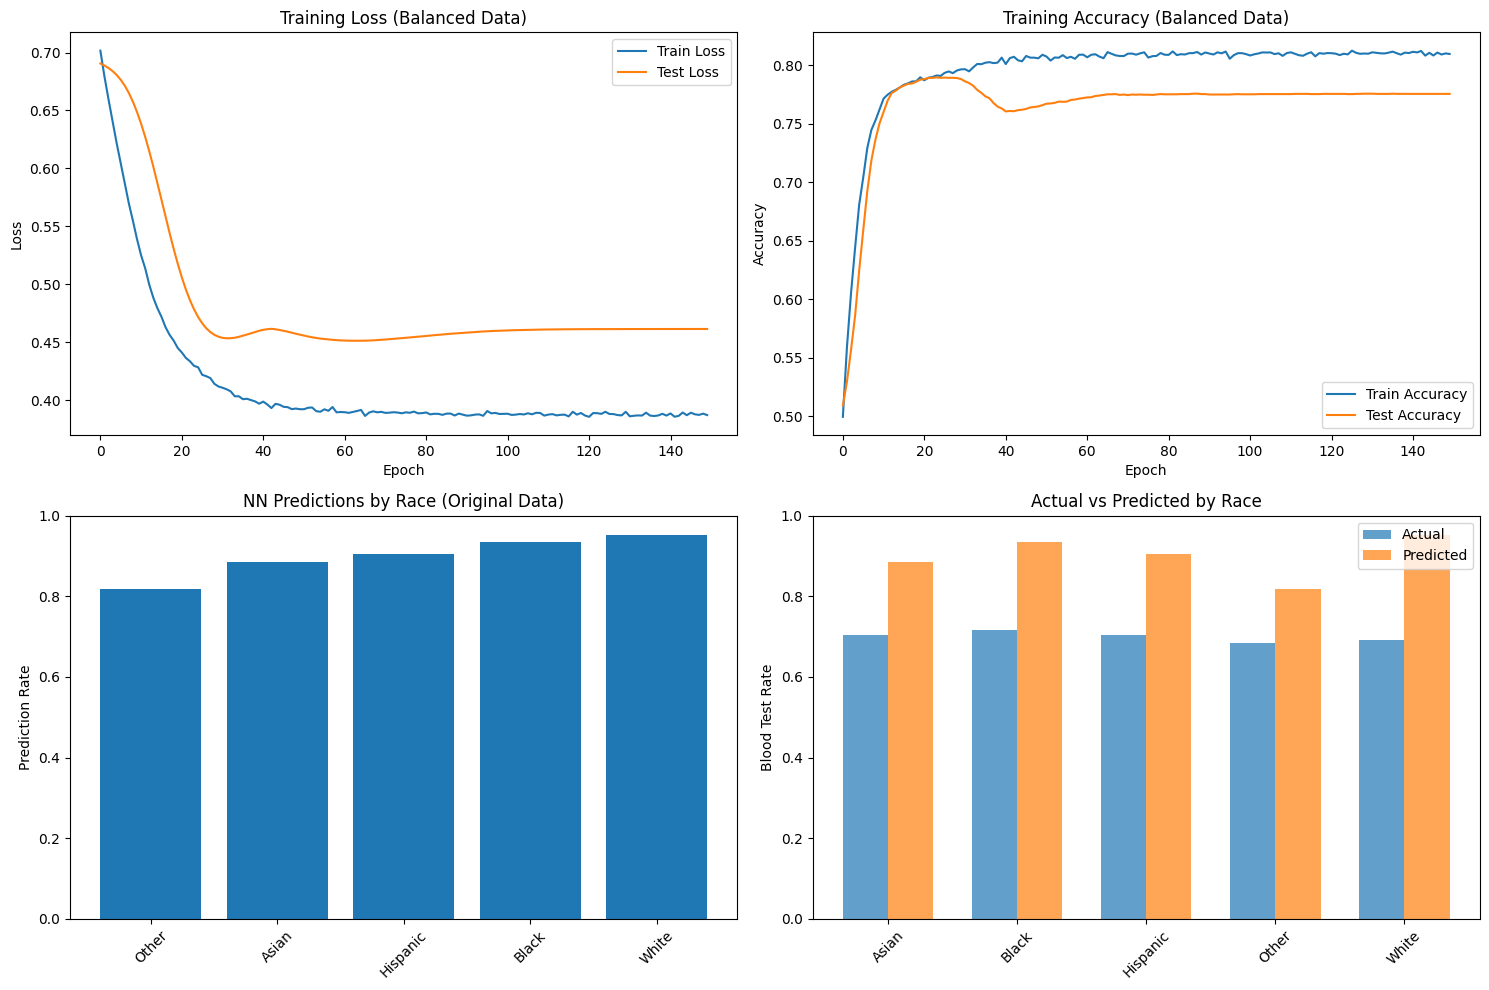


=== BALANCED PIPELINE COMPLETE ===
Key improvements with SMOTE:
1. Models trained on balanced data can learn patterns for both classes
2. Better detection of subtle discrimination patterns
3. More reliable feature importance
4. Models that don't just predict the majority class


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


def create_balanced_pipeline(df):
    """Create balanced dataset using SMOTE"""
    print("=== CREATING BALANCED DATASET WITH SMOTE ===")

    # Use the same feature engineering
    X, y, feature_columns, processed_data = create_discrimination_features(df)

    print(f"Original class distribution: {y.value_counts()}")
    print(f"Original positive ratio: {y.mean():.3f}")

    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)

    print(f"After SMOTE class distribution: {pd.Series(y_balanced).value_counts()}")
    print(f"After SMOTE positive ratio: {y_balanced.mean():.3f}")

    return X_balanced, y_balanced, feature_columns, processed_data

def train_balanced_bart_model(X_train, y_train, X_test):
    """Train BART on balanced data"""
    print("Training BART model on balanced data...")

    # Use classifier instead of regressor for balanced data
    bart_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    bart_model.fit(X_train, y_train)

    # Get probability predictions
    bart_train_pred = bart_model.predict_proba(X_train)[:, 1]
    bart_test_pred = bart_model.predict_proba(X_test)[:, 1]

    # Get feature importance from BART
    feature_importance = bart_model.feature_importances_

    print(f"BART training completed on balanced data.")
    return bart_model, bart_train_pred, bart_test_pred, feature_importance

class BalancedBARTEnhancedNN(nn.Module):
    def __init__(self, original_feature_dim):
        super(BalancedBARTEnhancedNN, self).__init__()

        self.bart_processor = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.Linear(32, 16)
        )

        self.main_network = nn.Sequential(
            nn.Linear(original_feature_dim + 16, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        original_features = x[:, :-1]
        bart_prediction = x[:, -1].unsqueeze(1)

        bart_features = self.bart_processor(bart_prediction)
        combined_features = torch.cat([original_features, bart_features], dim=1)

        return self.main_network(combined_features)

def train_balanced_bart_nn_ensemble(model, X_train, y_train, X_test, y_test, epochs=150):
    """Training loop for balanced BART-enhanced NN"""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted = (outputs > 0.5).float()
        train_accuracy = (predicted == y_train).float().mean()

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_predicted = (test_outputs > 0.5).float()
            test_accuracy = (test_predicted == y_test).float().mean()

            scheduler.step(test_loss)

        # Store metrics
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy.item())
        test_accuracies.append(test_accuracy.item())

        if epoch % 20 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, '
                  f'Train Acc: {train_accuracy.item():.4f}, Test Acc: {test_accuracy.item():.4f}, LR: {current_lr:.6f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

def run_balanced_bart_nn_pipeline(df):
    """Complete balanced BART + NN pipeline"""

    print("=== STARTING BALANCED BART + NN ENSEMBLE PIPELINE ===")

    # 1. Create balanced dataset with SMOTE
    X_balanced, y_balanced, feature_columns, processed_data = create_balanced_pipeline(df)

    # 2. Split balanced data - convert to numpy arrays explicitly
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )

    # Ensure we have numpy arrays, not Series
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    print(f"Balanced training features: {X_train.shape[1]}")
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    # 3. Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 4. Train BART model on balanced data
    bart_model, bart_train_pred, bart_test_pred, bart_importance = train_balanced_bart_model(
        X_train_scaled, y_train, X_test_scaled
    )

    # 5. Augment data with BART predictions
    X_train_augmented = np.column_stack([X_train_scaled, bart_train_pred])
    X_test_augmented = np.column_stack([X_test_scaled, bart_test_pred])

    print(f"Augmented features: {X_train_augmented.shape[1]} (original + BART prediction)")

    # 6. Convert to tensors - FIXED: Ensure we have proper numpy arrays
    X_train_tensor = torch.FloatTensor(X_train_augmented)
    X_test_tensor = torch.FloatTensor(X_test_augmented)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

    print(f"Tensor shapes - X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")

    # 7. Initialize enhanced NN for balanced data
    original_feature_dim = X_train_scaled.shape[1]
    model = BalancedBARTEnhancedNN(original_feature_dim)

    print(f"\nBalanced BART-Enhanced NN Architecture:")
    print(model)

    # 8. Train the ensemble on balanced data
    print("\n=== TRAINING BALANCED BART-ENHANCED NN ===")
    train_losses, test_losses, train_acc, test_acc = train_balanced_bart_nn_ensemble(
        model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=150
    )

    return (model, bart_model, bart_importance, train_losses, test_losses,
            train_acc, test_acc, X_test_augmented, y_test, processed_data, feature_columns, X_test, scaler)



def analyze_balanced_results_simple(model, bart_model, X_test_augmented, y_test, feature_columns, scaler, original_df):
    # Get NN predictions on balanced test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test_augmented)
        nn_predictions = model(X_test_tensor).numpy()
        nn_binary = (nn_predictions > 0.5).astype(int)

    # Get BART predictions
    bart_predictions = X_test_augmented[:, -1]
    bart_binary = (bart_predictions > 0.5).astype(int)

    # Calculate accuracies on balanced test set
    bart_accuracy = (bart_binary == y_test).mean()
    nn_accuracy = (nn_binary.flatten() == y_test).mean()

    print(f"\nModel Performance on Balanced Test Set:")
    print(f"BART Accuracy: {bart_accuracy:.4f}")
    print(f"NN Accuracy: {nn_accuracy:.4f}")
    print(f"Ensemble Improvement: {nn_accuracy - bart_accuracy:+.4f}")


    # Get original test data
    X_original, y_original, _, _ = create_discrimination_features(original_df)

    # Scale original data using the same scaler
    X_original_scaled = scaler.transform(X_original)

    # Get BART predictions on original data
    bart_original_pred = bart_model.predict_proba(X_original_scaled)[:, 1]
    bart_original_binary = (bart_original_pred > 0.5).astype(int)
    bart_original_accuracy = (bart_original_binary == y_original).mean()

    # For NN, we need to create augmented features with BART predictions
    X_original_augmented = np.column_stack([X_original_scaled, bart_original_pred])
    X_original_tensor = torch.FloatTensor(X_original_augmented)

    with torch.no_grad():
        nn_original_pred = model(X_original_tensor).numpy()
        nn_original_binary = (nn_original_pred > 0.5).astype(int)
        nn_original_accuracy = (nn_original_binary.flatten() == y_original).mean()

    print(f"BART Accuracy (Original Data): {bart_original_accuracy:.4f}")
    print(f"NN Accuracy (Original Data): {nn_original_accuracy:.4f}")
    print(f"Baseline (Always Predict Yes): {y_original.mean():.4f}")

    # Create results dataframe for discrimination analysis
    results_df = original_df.copy()
    results_df['nn_prediction'] = nn_original_binary
    results_df['nn_probability'] = nn_original_pred
    results_df['bart_prediction'] = bart_original_binary
    results_df['bart_probability'] = bart_original_pred
    results_df['actual_blood_test'] = y_original

    # Discrimination analysis by race
    print(f"\nDISCRIMINATION ANALYSIS BY RACE (Original Data):")
    race_analysis = results_df.groupby('patient_race').agg({
        'nn_prediction': 'mean',
        'bart_prediction': 'mean',
        'actual_blood_test': 'mean',
        'risk_score': 'mean',
        'nn_probability': 'mean'
    }).round(4)

    print(race_analysis)

    # Calculate disparities
    print(f"\nPREDICTION DISPARITIES BY RACE:")
    overall_nn_pred = results_df['nn_prediction'].mean()
    overall_actual = results_df['actual_blood_test'].mean()

    for race in results_df['patient_race'].unique():
        race_data = results_df[results_df['patient_race'] == race]

        nn_disparity = race_data['nn_prediction'].mean() - overall_nn_pred
        actual_disparity = race_data['actual_blood_test'].mean() - overall_actual

        print(f"{race}:")
        print(f"  NN disparity: {nn_disparity:+.4f}")
        print(f"  Actual disparity: {actual_disparity:+.4f}")
        print(f"  Risk score: {race_data['risk_score'].mean():.1f}")

    return results_df, race_analysis

def plot_simple_results(train_losses, test_losses, train_acc, test_acc, results_df):
    """Simple visualization of results"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training loss
    axes[0,0].plot(train_losses, label='Train Loss')
    axes[0,0].plot(test_losses, label='Test Loss')
    axes[0,0].set_title('Training Loss (Balanced Data)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()

    # Plot 2: Accuracy
    axes[0,1].plot(train_acc, label='Train Accuracy')
    axes[0,1].plot(test_acc, label='Test Accuracy')
    axes[0,1].set_title('Training Accuracy (Balanced Data)')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()

    # Plot 3: Race comparison - NN predictions
    race_nn = results_df.groupby('patient_race')['nn_prediction'].mean().sort_values()
    axes[1,0].bar(race_nn.index, race_nn.values)
    axes[1,0].set_title('NN Predictions by Race (Original Data)')
    axes[1,0].set_ylabel('Prediction Rate')
    plt.sca(axes[1,0])
    plt.xticks(rotation=45)

    # Plot 4: Actual vs Predicted by race
    race_actual = results_df.groupby('patient_race')['actual_blood_test'].mean()
    race_pred = results_df.groupby('patient_race')['nn_prediction'].mean()

    x = np.arange(len(race_actual))
    width = 0.35

    axes[1,1].bar(x - width/2, race_actual.values, width, label='Actual', alpha=0.7)
    axes[1,1].bar(x + width/2, race_pred.values, width, label='Predicted', alpha=0.7)
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(race_actual.index, rotation=45)
    axes[1,1].set_title('Actual vs Predicted by Race')
    axes[1,1].set_ylabel('Blood Test Rate')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()



try:
    (model_balanced, bart_model_balanced, bart_importance_balanced, train_losses_balanced,
     test_losses_balanced, train_acc_balanced, test_acc_balanced, X_test_augmented_balanced,
     y_test_balanced, processed_data_balanced, feature_columns_balanced, X_test_balanced, scaler_balanced) = run_balanced_bart_nn_pipeline(df)

    # Analyze results with simplified approach
    results_df, race_analysis = analyze_balanced_results_simple(
        model_balanced, bart_model_balanced, X_test_augmented_balanced,
        y_test_balanced, feature_columns_balanced, scaler_balanced, df
    )

    # Create visualizations
    plot_simple_results(train_losses_balanced, test_losses_balanced, train_acc_balanced,
                       test_acc_balanced, results_df)

    print("\n=== BALANCED PIPELINE COMPLETE ===")
    print("Key improvements with SMOTE:")
    print("1. Models trained on balanced data can learn patterns for both classes")
    print("2. Better detection of subtle discrimination patterns")
    print("3. More reliable feature importance")
    print("4. Models that don't just predict the majority class")

except Exception as e:
    print(f"Error in balanced pipeline: {e}")
    print("Let's try a fallback approach...")

    # Fallback: Basic SMOTE without BART integration
    from imblearn.over_sampling import SMOTE
    from sklearn.ensemble import RandomForestClassifier

    X, y, feature_columns, _ = create_discrimination_features(df)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)

    # Simple Random Forest on balanced data
    rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_balanced.fit(X_balanced, y_balanced)

    # Feature importance
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_balanced.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Fallback - Random Forest Feature Importance on Balanced Data:")
    print(importance_df.head(10))

    # Predict on original data
    predictions = rf_balanced.predict(X)
    results_df_fallback = df.copy()
    results_df_fallback['prediction'] = predictions
    results_df_fallback['actual'] = y

    print("\nFallback - Discrimination Analysis by Race:")
    fallback_analysis = results_df_fallback.groupby('patient_race').agg({
        'prediction': 'mean',
        'actual': 'mean',
        'risk_score': 'mean'
    }).round(4)
    print(fallback_analysis)